<a href="https://colab.research.google.com/github/katia-kitaguti/sales-prediction-model/blob/main/202312_%7C_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [61]:
# Open files uploaded to Colab
import zipfile

# Deal with dataframes
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with dates
from matplotlib.dates import DateFormatter
from datetime import date

#Stationary
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# PmdArima -> Optimizer
import pmdarima as pm
from ThymeBoost import ThymeBoost as tb

#Sklearn metrics
from sklearn.metrics import mean_squared_error

#Warnings
import warnings

#Create a table
from tabulate import tabulate

In [32]:
# ! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.5 MB/s eta 0:00:00


In [41]:
# ! pip install ThymeBoost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 1.1 MB/s eta 0:00:00


# Base

Before running the following code cell, you should follow the steps specified in the [article](https://medium.com/@vishakha1203/easiest-way-to-upload-large-datasets-to-google-colab-1f89231844dc)

In [2]:
!unzip /content/Kaggle_Rossman_Sales.zip

Archive:  /content/Kaggle_Rossman_Sales.zip
  inflating: store.csv               
  inflating: test.csv                
  inflating: train.csv               


In [3]:
df_test_raw = pd.read_csv('/content/test.csv', low_memory=False)
df_train_raw = pd.read_csv('/content/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/content/store.csv', low_memory=False)

In [12]:
df_store_sales = df_train_raw.merge(df_store_raw, how='left', on='Store')
df_store_sales

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [13]:
df_store_sales['Month_Year'] = pd.to_datetime(df_store_sales['Date']).dt.strftime('%Y-%m')
df_store_sales['Month'] = pd.to_datetime(df_store_sales['Date']).dt.month
df_store_sales['Year'] = pd.to_datetime(df_store_sales['Date']).dt.year
df_store_sales

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month_Year,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015-07,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015-07,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015-07,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015-07,7,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013-01,1,2013
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013-01,1,2013
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013-01,1,2013
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,870.0,NaN,NaN,0,NaN,NaN,NaN,2013-01,1,2013


# Exploratory Data Analysis (EDA)

In [14]:
df_store_raw.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


The df_store_raw gives information of 1115 Rossman' stores.

In [15]:
df_train_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [16]:
if len(df_train_raw[df_train_raw[['Store', 'Date']].duplicated()==True]) ==0:
  print("This df_train_raw dataframe has one value for store and date per line, which means that one line means the daily sales done by each store")
else:
  print("Check")

This df_train_raw dataframe has one value for store and date per line, which means that one line means the daily sales done by each store


In [17]:
#Indexing date
df_store_sales = df_store_sales.set_index('Date')
df_store_sales.index = pd.to_datetime(df_store_sales.index)
df_store_sales

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month_Year,Month,Year
Date,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015-07,7,2015
2015-07-31,2,5,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015-07,7,2015
2015-07-31,3,5,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07,7,2015
2015-07-31,4,5,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015-07,7,2015
2015-07-31,5,5,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015-07,7,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013-01,1,2013
2013-01-01,1112,2,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013-01,1,2013
2013-01-01,1113,2,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013-01,1,2013


## Trends and Seasonality

We will check if there is a sales variation according to the month, promo, promo2, year.

In [18]:
df_store_sales_monthly = df_store_sales.groupby(["Month", "Year", "Promo", "Promo2"]).agg(Total_Monthly_Sales= ("Sales", "sum"))
df_store_sales_monthly = df_store_sales_monthly.reset_index()
df_store_sales_monthly

,Month,Year,Promo,Promo2,Total_Monthly_Sales
0,1,2013,0,0,51088204
1,1,2013,0,1,45881773
2,1,2013,1,0,42685307
3,1,2013,1,1,40476923
4,1,2014,0,0,52672829
...,...,...,...,...,...
119,12,2013,1,1,57382657
120,12,2014,0,0,61428317
121,12,2014,0,1,43393037
122,12,2014,1,0,55828372


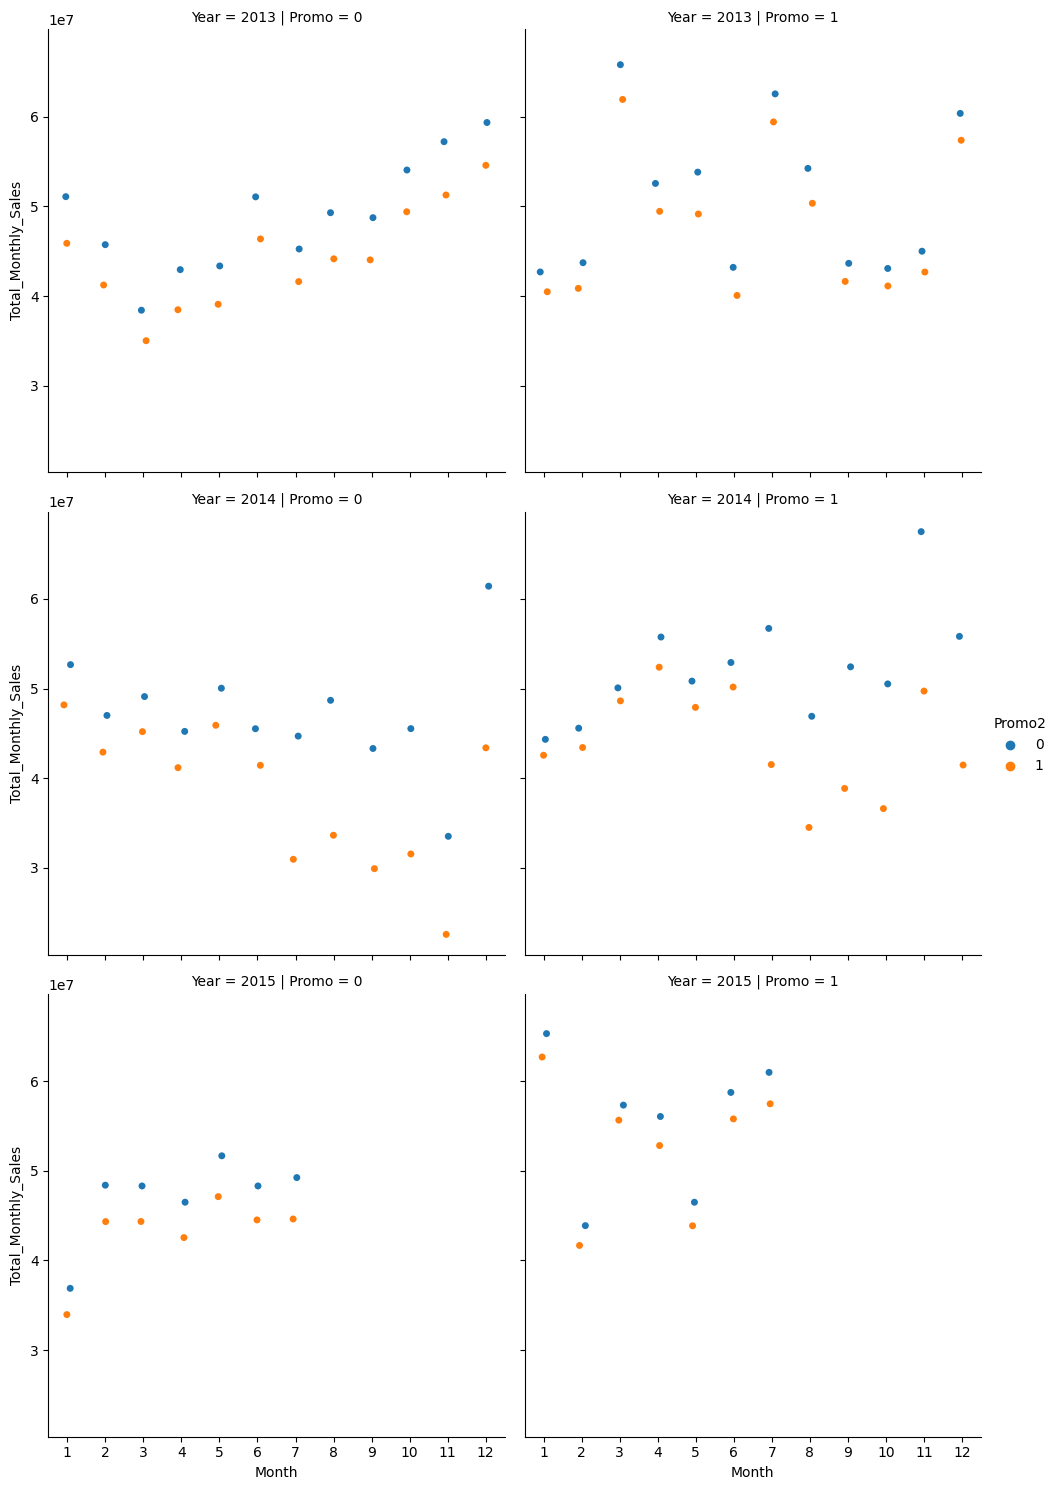

In [19]:
sns.catplot(x="Month", y="Total_Monthly_Sales",
               col="Promo",
               hue="Promo2",
               row="Year",
               data = df_store_sales_monthly)

We can see a tendency of increasing sales in the end of the year, reflected by the Christmas.

In [20]:
#Trend over days of the week
df_store_sales_daysofweek = df_store_sales.groupby(["DayOfWeek", "Promo"]).agg(Total_DayOfWeek_Sales= ("Sales", "sum"))
df_store_sales_daysofweek = df_store_sales_daysofweek.reset_index()
df_store_sales_daysofweek

,DayOfWeek,Promo,Total_DayOfWeek_Sales
0,1,0,375323829
1,1,1,754879183
2,2,0,382090703
3,2,1,638321227
4,3,0,368921884
5,3,1,586040979
6,4,0,347985910
7,4,1,563191799
8,5,0,421782843
9,5,1,558773098


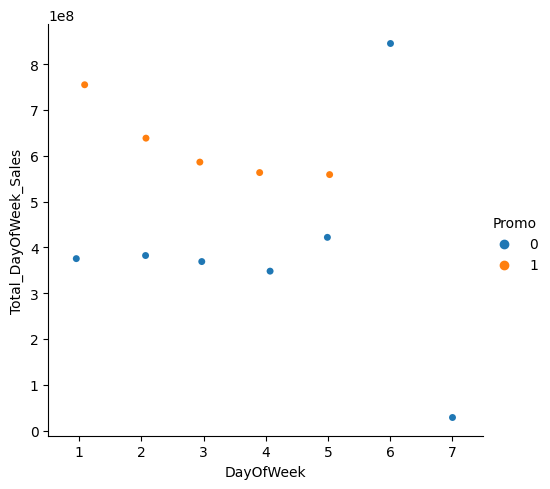

In [21]:
sns.catplot(x="DayOfWeek", y="Total_DayOfWeek_Sales",
               hue="Promo",
               data = df_store_sales_daysofweek)

There is a tendency of not having promotions on weekends, justified by increasing of the profit when people do the chores more often.

In [22]:
df_store_sales_avg_daily = df_store_sales.groupby(['Date', 'DayOfWeek', 'Month_Year', 'Month', 'Year']).agg(Avg_Daily_Sales = ("Sales", "mean")).reset_index()
df_store_sales_avg_daily = df_store_sales_avg_daily.set_index('Date')
df_store_sales_avg_daily.index = pd.to_datetime(df_store_sales_avg_daily.index)
df_store_sales_avg_daily

,DayOfWeek,Month_Year,Month,Year,Avg_Daily_Sales
Date,,,,,
2013-01-01,2,2013-01,1,2013,87.284560
2013-01-02,3,2013-01,1,2013,6233.030493
2013-01-03,4,2013-01,1,2013,5693.112108
2013-01-04,5,2013-01,1,2013,5954.218834
2013-01-05,6,2013-01,1,2013,5337.751570
...,...,...,...,...,...
2015-07-27,1,2015-07,7,2015,9602.952466
2015-07-28,2,2015-07,7,2015,8174.953363
2015-07-29,3,2015-07,7,2015,7623.284305


In [23]:
df_store_sales_avg_daily.describe()

,DayOfWeek,Month,Year,Avg_Daily_Sales
count,942.000000,942.000000,942.000000,942.000000
mean,3.997877,5.961783,2013.837580,5782.702036
std,1.998404,3.350357,0.766009,2888.462029
min,1.000000,1.000000,2013.000000,87.284560
25%,2.000000,3.000000,2013.000000,5321.408512
50%,4.000000,6.000000,2014.000000,6036.153617
75%,6.000000,9.000000,2014.000000,7530.909865
max,7.000000,12.000000,2015.000000,14012.150673


In [24]:
# Define a function to remove outliers using IQR method
def remove_outliers_iqr(data_frame, column_name):
    Q1 = data_frame[column_name].quantile(0.25)
    Q3 = data_frame[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return data_frame[(data_frame[column_name] >= lower_bound) & (data_frame[column_name] <= upper_bound)]

# Remove outliers from the column
df_avg_daily_noOutliers = remove_outliers_iqr(df_store_sales_avg_daily, "Avg_Daily_Sales")

# Base without outliers
df_avg_daily_noOutliers[['Avg_Daily_Sales']].describe()

,Avg_Daily_Sales
count,771.000000
mean,6823.563981
std,1448.521645
min,2966.606278
25%,5642.732735
50%,6582.350673
75%,7662.439910
max,10818.773991


## Stationarity of Time Series

In order to use time series forecasting models, we have to validate whether our time series data is stationary, in other words, they are constant mean, constant variance and constant covariance with time.

There is 2 ways to check statinarity in time series data (reference in [medium post](https://medium.com/analytics-vidhya/predicting-sales-time-series-analysis-forecasting-with-python-b81d3e8ff03f))

1) Rolling Mean: this analysis is used to assess the model's stability over time. The window is rolled on a weekly basis, and the mean is taken also on a weekly basis. With this visualization test, we can compared the Rolled data with the original data to check if there are stationary or not.

2) Dicky-Fuller Test: This is a statistical test uses the p-value to understand if we can reject the null hypothesis. In this case, the null hypothesis (p-value < 0.5) is that the data is not stationary.  

<Axes: xlabel='Date'>

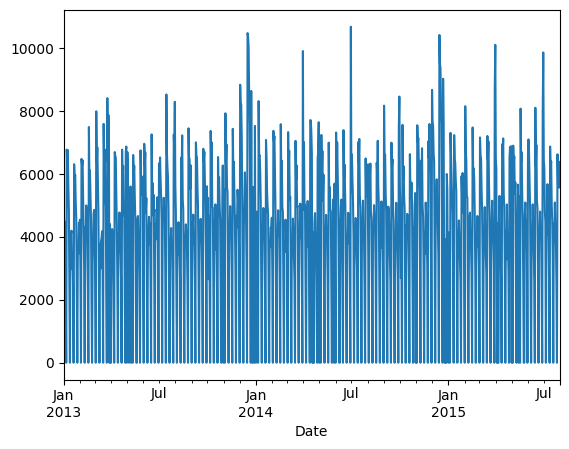

In [25]:
# Data Preparation: input should be float type
df_store_sales['Sales'] = df_store_sales['Sales'] * 1.0
# Assigning one store from each category
sales_a = df_store_sales[df_store_sales.Store == 2]['Sales']
# Check the trend and plot in a weekly frequency
sales_a.resample('W').sum()
sales_a.plot()

<ipython-input-26-95cf74eb4f6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg_daily_noOutliers['Avg_Daily_Sales'] = df_avg_daily_noOutliers['Avg_Daily_Sales'] * 1.0


<Axes: xlabel='Date'>

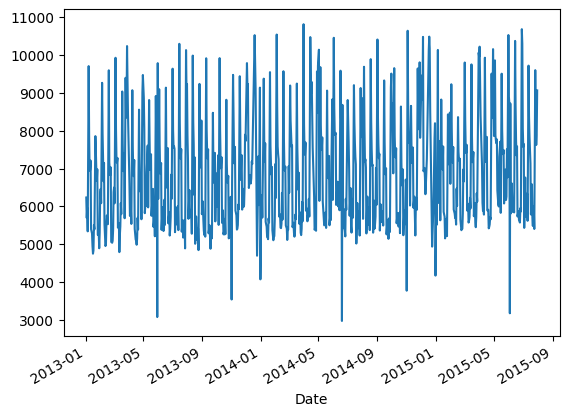

In [26]:
# Data Preparation: input should be float type
df_avg_daily_noOutliers['Avg_Daily_Sales'] = df_avg_daily_noOutliers['Avg_Daily_Sales'] * 1.0
# Trying to analyse the average of all stores
sales_avg = df_avg_daily_noOutliers['Avg_Daily_Sales']
# Check the trend and plot in a weekly frequency
sales_avg.resample('W').mean()
sales_avg.plot()

We can also see that the sales tend to peak in the end of the year

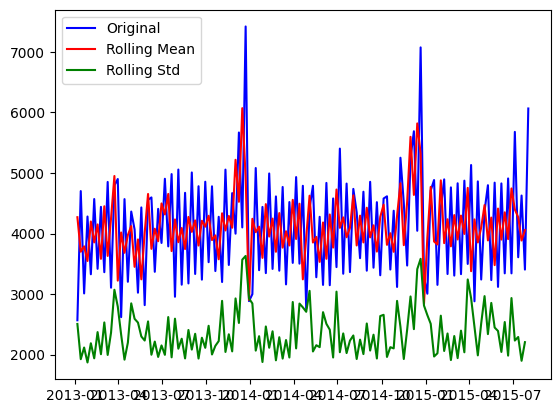

Results of Dickey-Fuller Test:
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [28]:
# Function to test the stationarity
def test_stationarity(timeseries):

    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
# Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

  # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)
# Testing stationarity of store type a
test_stationarity(sales_a)

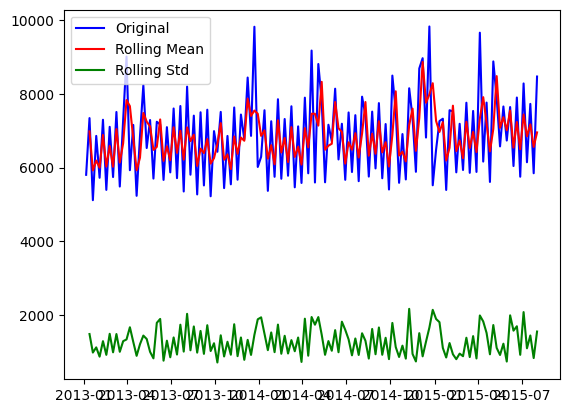

Results of Dickey-Fuller Test:
ADF Statistic: -7.140998
p-value: 0.000000
Critical Values:
1% -3.4390179167598367
5% -2.8653655786032237
10% -2.5688071343462777


In [27]:
# Function to test the stationarity
def test_stationarity(timeseries):

    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
# Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

  # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)
# Testing stationarity of the average sales of all stores
test_stationarity(sales_avg)

Due to the fact that p-value < 0.05, we can refuse the null hypothesis that it is not a stationary.

So, we don't have to apply any transformation (used when the time series is not stationary)

Even doing the all stores` sales average, p-value continues to be lower than 0.05, which means we can refuse the null hypothesis.

# Building the Model

## Train-Test Split

In [38]:
df_store_sales_avg_daily.sort_values(by='Date', inplace=True)

# Calculate the index for the split (70% training, 30% testing)
split_index = int(0.7 * len(df_store_sales_avg_daily))

# Split the DataFrame into training and testing sets
train_data = df_store_sales_avg_daily.iloc[:split_index]['Avg_Daily_Sales']
test_data = df_store_sales_avg_daily.iloc[split_index:]['Avg_Daily_Sales']

## Comparing Models

In [39]:
# Fit auto_arima model
arima = pm.auto_arima(train_data,
                      seasonal=False,
                      trace=True)
pmd_predictions = arima.predict(n_periods=len(test_data))
arima_mae = np.mean(np.abs(test_data - pmd_predictions))
arima_rmse = (np.mean((test_data - pmd_predictions)**2))**.5
arima_mape = np.sum(np.abs(pmd_predictions - test_data))/(np.sum((np.abs(test_data))))


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13411.618, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12758.508, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13082.769, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=12634.954, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=12545.393, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=12518.448, Time=0.16 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=12517.591, Time=0.18 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=2.48 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=12317.377, Time=0.71 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=12345.811, Time=0.51 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=12314.791, Time=0.86 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=12346.559, Time=0.48 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   :

In [46]:
# Getting the order
auto_order = arima.get_params()['order']

boosted_model = tb.ThymeBoost(verbose=1)

output = boosted_model.fit(train_data,
                           trend_estimator='arima',
                           arima_order=auto_order,
                           global_cost='mse')
predicted_output = boosted_model.predict(output,len(test_data))
tb_mae = np.mean(np.abs(test_data - predicted_output['predictions']))
tb_rmse = (np.mean((test_data - predicted_output['predictions'])**2))**.5
tb_mape = np.sum(np.abs(predicted_output['predictions'] - test_data)) / (np.sum((np.abs(test_data))))

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 8035249.434369059
********** Round 2 **********
Using Split: None
Fitting global with trend model:
arima((5, 0, 1))
seasonal model:
None
cost: 7417927.08036083
********** Round 3 **********
Using Split: None
Fitting global with trend model:
arima((5, 0, 1))
seasonal model:
None
cost: 7250666.203428559
********** Round 4 **********
Using Split: None
Fitting global with trend model:
arima((5, 0, 1))
seasonal model:
None
cost: 7196175.691051288
********** Round 5 **********
Using Split: None
Fitting global with trend model:
arima((5, 0, 1))
seasonal model:
None
cost: 6370514.027805551
********** Round 6 **********
Using Split: None
Fitting global with trend model:
arima((5, 0, 1))
seasonal model:
None
cost: 5884890.18059435
********** Round 7 **********
Using Split: None
Fitting global with trend model:
arima((5, 0, 1))
seasonal model:
None
cost: 5753607.860

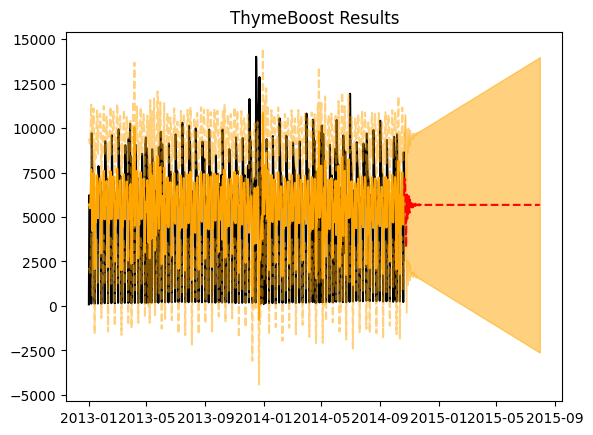

In [44]:
boosted_model.plot_results(output, predicted_output)

In [48]:
boosted_model = tb.ThymeBoost(verbose=1)
output = boosted_model.fit(train_data,
                            trend_estimator='arima',
                            arima_order='auto',
                            global_cost='mse')
predicted_output = boosted_model.predict(output, len(test_data))
tb_mae_auto = np.mean(np.abs(test_data - predicted_output['predictions']))
tb_rmse_auto = (np.mean((test_data - predicted_output['predictions'])**2))**.5
tb_mape_auto = np.sum(np.abs(predicted_output['predictions'] - test_data)) / (np.sum((np.abs(test_data))))

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 8035249.434369059
********** Round 2 **********
Using Split: None
Fitting global with trend model:
arima(auto)
seasonal model:
None
cost: 7610009.063743889
********** Round 3 **********
Using Split: None
Fitting global with trend model:
arima(auto)
seasonal model:
None
cost: 4657973.954014912
********** Round 4 **********
Using Split: None
Fitting global with trend model:
arima(auto)
seasonal model:
None
cost: 4457810.00692275
Boosting Terminated 
Using round 4


In [56]:
boosted_model = tb.ThymeBoost(verbose=1)
output = boosted_model.fit(train_data,
                            trend_estimator=['linear', 'arima'],
                            arima_order='auto',
                            global_cost='mse')
predicted_output = boosted_model.predict(output, len(test_data))
tb_mae_linear = np.mean(np.abs(test_data - predicted_output['predictions']))
tb_rmse_linear = (np.mean((test_data - predicted_output['predictions'])**2))**.5
tb_mape_linear = np.sum(np.abs(predicted_output['predictions'] - test_data)) / (np.sum((np.abs(test_data))))

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 8035249.434369059
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 7971025.979282185
********** Round 3 **********
Using Split: None
Fitting global with trend model:
arima(auto)
seasonal model:
None
cost: 7425084.732336341
Boosting Terminated 
Using round 3


In [63]:
results_data = [["Auto-Arima", arima_mape, arima_rmse, arima_mae],
                ["Boosted Arima", tb_mape, tb_rmse, tb_mae],
                ["Boosted Auto-Arima",tb_mape_auto, tb_rmse_auto , tb_mae_auto],
                ["Boosted Linear Auto-Arima", tb_mape_linear, tb_rmse_linear, tb_mae_linear]]

cols_name = ["Model", "MAPE", "RMSE", "MAE"]

# Find the index of the row with the minimum MAPE value
min_mape_index = min(range(len(results_data)), key=lambda i: results_data[i][1])

# Define ANSI escape codes for color formatting
color_start = '\033[92m'  # Green color
color_end = '\033[0m'  # Reset color

# Iterate through rows and print, coloring the row with the minimum MAPE value
for i, row in enumerate(results_data):
    if i == min_mape_index:
        # Print the row with green color
        print(color_start + tabulate([row], headers=cols_name, tablefmt="fancy_grid") + color_end)
    else:
        # Print other rows without color
        print(tabulate([row], headers=cols_name, tablefmt="fancy_grid"))

╒════════════╤══════════╤═════════╤════════╕
│ Model      │     MAPE │    RMSE │    MAE │
╞════════════╪══════════╪═════════╪════════╡
│ Auto-Arima │ 0.377028 │ 3025.71 │ 2270.1 │
╘════════════╧══════════╧═════════╧════════╛
╒═══════════════╤══════════╤═════════╤═════════╕
│ Model         │     MAPE │    RMSE │     MAE │
╞═══════════════╪══════════╪═════════╪═════════╡
│ Boosted Arima │ 0.367679 │ 3015.56 │ 2213.82 │
╘═══════════════╧══════════╧═════════╧═════════╛
╒════════════════════╤═════════╤═════════╤═════════╕
│ Model              │    MAPE │    RMSE │     MAE │
╞════════════════════╪═════════╪═════════╪═════════╡
│ Boosted Auto-Arima │ 0.35206 │ 2689.19 │ 2119.77 │
╘════════════════════╧═════════╧═════════╧═════════╛
╒═══════════════════════════╤══════════╤═════════╤═════════╕
│ Model                     │     MAPE │    RMSE │     MAE │
╞═══════════════════════════╪══════════╪═════════╪═════════╡
│ Boosted Linear Auto-Arima │ 0.367679 │ 3015.56 │ 2213.82 │
╘════════════════════

According to the KPIs above, we can see that Boosted Auto-Arima performed better, since it`s mean absolute percentage error is lower than the other models.

## Selecting the Model

In [67]:
# Train the ThymeBoost model
boosted_model_selected = tb.ThymeBoost(verbose=1)
output_selected = boosted_model_selected.fit(train_data,
                            trend_estimator='arima',
                            arima_order='auto',
                            global_cost='mse')

# Specifying the future days to predict
num_future_steps = 730

# Putting in the model
future_output = boosted_model.predict(output_selected, num_future_steps)

# Extract the predictions for the future time points
future_predictions = future_output['predictions']


********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 8035249.434369059
********** Round 2 **********
Using Split: None
Fitting global with trend model:
arima(auto)
seasonal model:
None
cost: 7610009.063743889
********** Round 3 **********
Using Split: None
Fitting global with trend model:
arima(auto)
seasonal model:
None
cost: 4657973.954014912
********** Round 4 **********
Using Split: None
Fitting global with trend model:
arima(auto)
seasonal model:
None
cost: 4457810.00692275
Boosting Terminated 
Using round 4


In [69]:
future_predictions

2014-10-22    5314.786818
2014-10-23    6024.541106
2014-10-24    6441.065033
2014-10-25    6154.676897
2014-10-26    3721.306840
                 ...     
2016-10-16    4903.000140
2016-10-17    5893.116200
2016-10-18    6194.956345
2016-10-19    5072.867495
2016-10-20    5270.168540
Freq: D, Name: predictions, Length: 730, dtype: float64

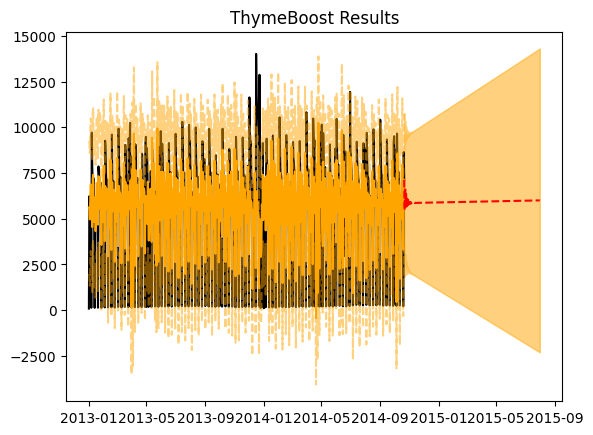

In [68]:
boosted_model_selected.plot_results(output, predicted_output)

In [83]:
df_train_data = pd.DataFrame(train_data)
df_train_data = df_train_data.reset_index()
df_train_data


,Date,Avg_Daily_Sales
0,2013-01-01,87.284560
1,2013-01-02,6233.030493
2,2013-01-03,5693.112108
3,2013-01-04,5954.218834
4,2013-01-05,5337.751570
...,...,...
654,2014-10-17,5828.541176
655,2014-10-18,5289.554011
656,2014-10-19,219.241711
657,2014-10-20,8640.459893


In [84]:
df_test_data = pd.DataFrame(test_data)
df_test_data = df_test_data.reset_index()
df_test_data


,Date,Avg_Daily_Sales
0,2014-10-22,6555.970053
1,2014-10-23,6912.948663
2,2014-10-24,6976.779679
3,2014-10-25,5234.977540
4,2014-10-26,234.608556
...,...,...
278,2015-07-27,9602.952466
279,2015-07-28,8174.953363
280,2015-07-29,7623.284305
281,2015-07-30,7891.348879


In [88]:
df_future_predictions = pd.DataFrame(future_predictions)
df_future_predictions = df_future_predictions.reset_index()
df_future_predictions = df_future_predictions.rename(columns ={"index" : "Date", "predictions": "Avg_Daily_Sales"})
df_future_predictions

,Date,Avg_Daily_Sales
0,2014-10-22,5314.786818
1,2014-10-23,6024.541106
2,2014-10-24,6441.065033
3,2014-10-25,6154.676897
4,2014-10-26,3721.306840
...,...,...
725,2016-10-16,4903.000140
726,2016-10-17,5893.116200
727,2016-10-18,6194.956345
728,2016-10-19,5072.867495


In [89]:
df_future_values_predictions = df_future_predictions[ df_future_predictions['Date'] > '2015-07-31']
df_future_values_predictions = df_future_values_predictions.rename(columns= {'index':'EmissionMonth' ,'predicted_mean':'ValidValue' })
df_future_values_predictions

,Date,Avg_Daily_Sales
283,2015-08-01,5585.995154
284,2015-08-02,4491.163696
285,2015-08-03,6136.250236
286,2015-08-04,6497.896678
287,2015-08-05,4695.671407
...,...,...
725,2016-10-16,4903.000140
726,2016-10-17,5893.116200
727,2016-10-18,6194.956345
728,2016-10-19,5072.867495


In [90]:
df_all_wth_pred = df_train_data.append(df_test_data, ignore_index=True)
df_all_wth_pred = df_all_wth_pred.append(df_future_values_predictions, ignore_index=True)
df_all_wth_pred

,Date,Avg_Daily_Sales
0,2013-01-01,87.284560
1,2013-01-02,6233.030493
2,2013-01-03,5693.112108
3,2013-01-04,5954.218834
4,2013-01-05,5337.751570
...,...,...
1384,2016-10-16,4903.000140
1385,2016-10-17,5893.116200
1386,2016-10-18,6194.956345
1387,2016-10-19,5072.867495


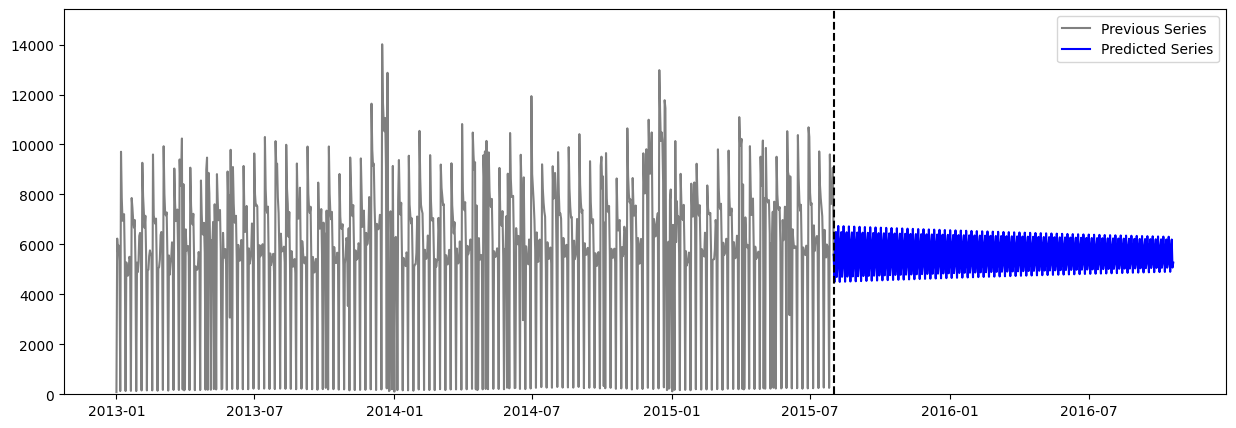

In [91]:
start_date = date(2015, 8, 1)
df_all_wth_pred_index = df_all_wth_pred.set_index('Date')
base = df_all_wth_pred_index.loc[df_all_wth_pred_index.index <= pd.to_datetime(start_date)]
predicted = df_all_wth_pred_index.loc[df_all_wth_pred_index.index >= pd.to_datetime(start_date)]
plt.figure(figsize=(15,5))
plt.plot(base.index, base.Avg_Daily_Sales, color='gray', label='Previous Series')

# Plot predicted series with a different color (e.g., red)
plt.plot(predicted.index, predicted.Avg_Daily_Sales, color='blue', label='Predicted Series')

# Add a vertical line at the start date with a black dashed line
plt.axvline(x=start_date, color='black', linestyle='--')

# Set y-axis limits
plt.ylim(0, max(base['Avg_Daily_Sales'].max(), predicted['Avg_Daily_Sales'].max()) * 1.1)

# Show the legend
plt.legend()

# Show the plot
plt.show()

# References

https://medium.com/@vishakha1203/easiest-way-to-upload-large-datasets-to-google-colab-1f89231844dc


https://github.com/ronaldoi9/rossmann_sales_prediction/blob/master/rossmann_sales_prediction.ipynb

https://www.kaggle.com/datasets/pratyushakar/rossmann-store-sales/

https://www.kaggle.com/c/rossmann-store-sales/code

https://medium.com/analytics-vidhya/predicting-sales-time-series-analysis-forecasting-with-python-b81d3e8ff03f

https://towardsdatascience.com/predicting-sales-611cb5a252de

https://aigents.co/learn?search=+sales+arima

https://medium.com/mlearning-ai/time-series-forecasting-predicting-stock-prices-using-an-arima-model-627db94590e6

https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53

https://medium.com/towards-data-science/time-series-modeling-with-arima-to-predict-future-house-price-9b180c3bbd2f

https://towardsdatascience.com/gradient-boosted-arima-for-time-series-forecasting-e093f80772f6